In [57]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pickle
import sys
from os.path import join
import unicodedata
import logging
from collections import Counter
sys.path.append('../../wikinet_2/')

from src.utils.data import pickle_load, load_wiki_data

import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold
from sklearn.decomposition import PCA
from scipy.stats import spearmanr, kendalltau
import Levenshtein

import faiss

In [38]:
log_formatter = logging.Formatter(fmt='%(levelname)s:%(asctime)s:%(message)s', datefmt='%I:%M:%S %p')
console_handler = logging.StreamHandler(stream=sys.stdout)
console_handler.setFormatter(log_formatter)
logger = logging.getLogger(__name__)
logger.addHandler(console_handler)
logger.level = 10 
logger.handlers.pop()

<StreamHandler stdout (NOTSET)>

In [184]:
MAX_CHAR_SIZE = 40
HIDDEN_SIZE = 64
CHAR_SIZE = 8
DATA_PATH = '../data/'
YAMADA_MODEL = 'yamada_model.pickle'
BATCH_SIZE = 2 ** 16
DEVICE = 0
NUM_WORKERS = 8
use_cuda = torch.cuda.is_available()

In [40]:
class Args:
    def __init__(self):
        pass
args = Args()
args.__dict__['data_path'] = DATA_PATH

In [41]:
class Dictionary(object):
    NULL = '<NULL>'
    UNK = 'UNK'

    @staticmethod
    def normalize(token):
        return unicodedata.normalize('NFD', token)

    def __init__(self):
        self.tok2ind = {self.NULL: 0, self.UNK: 1, 'EOT': 2}
        self.ind2tok = {0: self.NULL, 1: self.UNK, 2: 'EOT_Tok'}

    def __len__(self):
        return len(self.tok2ind)

    def __iter__(self):
        return iter(self.tok2ind)

    def __contains__(self, key):
        if type(key) == int:
            return key in self.ind2tok
        elif type(key) == str:
            return self.normalize(key) in self.tok2ind

    def __getitem__(self, key):
        if type(key) == int:
            return self.ind2tok.get(key, self.UNK)
        if type(key) == str:
            return self.tok2ind.get(self.normalize(key),
                                    self.tok2ind.get(self.UNK))

    def __setitem__(self, key, item):
        if type(key) == int and type(item) == str:
            self.ind2tok[key] = item
        elif type(key) == str and type(item) == int:
            self.tok2ind[key] = item
        else:
            raise RuntimeError('Invalid (key, item) types.')

    def add(self, token):
        token = self.normalize(token)
        if token not in self.tok2ind:
            index = len(self.tok2ind)
            self.tok2ind[token] = index
            self.ind2tok[index] = token

    def tokens(self):
        """Get dictionary tokens.

        Return all the words indexed by this dictionary, except for special
        tokens.
        """
        tokens = [k for k in self.tok2ind.keys()
                  if k not in {'<NULL>', 'EOT', 'UNK'}]
        return tokens

In [42]:
def normal_initialize(dim_0=1000, dim_1=16):
    """Initialize with normal distribution of std = 1 / sqrt(dim_1). Set O index to all zeros."""
    stdv = 1 / np.sqrt(dim_1)
    embs = np.random.normal(0, scale=stdv, size=(dim_0, dim_1))
    embs[0] = np.zeros(dim_1)

    return embs

In [43]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [44]:
def mse(input, target):
    b = input.shape[0]
    
    return ((input - target) * (input - target)).sum() / b

In [45]:
def setup(args, logger):
    
    # Yamada model
    logger.info("Loading Yamada model.")
    yamada_model = pickle_load(join(DATA_PATH, 'yamada', YAMADA_MODEL))
    logger.info("Model loaded.")

    # Training Data
    train_data, dev_data, test_data = load_wiki_data('proto', args, yamada_model)
    logger.info("Training data loaded.")
    logger.info("Train : {}, Dev : {}, Test :{}".format(len(train_data), len(dev_data), len(test_data)))

    return yamada_model, train_data, dev_data, test_data

In [46]:
def index_chars(data):
    """Put all the chars in data counter."""
    chars = Counter()
    for i, mention in enumerate(data):
        if i % 10**6 == 0 and i  != 0:
            print(i, len(chars))
        chars.update([ch for ch in list(mention)])
    return chars

In [47]:
def create_mention_data(data):
    mentions = []
    for d in data:
        examples = d[1]
        mentions.extend([mention for mention, ent in examples])
        
    return mentions

In [53]:
def create_char_dict(train_mentions, dev_mentions, min_count=10):
    char_counter = index_chars(train_mentions + dev_mentions)

    char_final = set()
    for char, count in char_counter.most_common():
        if count > min_count:
            char_final.add(char)
            
    char_dict = Dictionary()
    for ch in char_final:
        char_dict.add(ch)
        
    return char_dict

In [49]:
def equalize_len(data, max_size, char_dict):
    l = len(data)
    arr = np.zeros(max_size, dtype=np.int64)
    
    if l >= max_size:
        arr[:max_size] = data[:max_size]
        arr[max_size-1] = char_dict['EOT']
    else:
        arr[:l] = data
        arr[l] = char_dict['EOT']

    return arr

In [50]:
def create_arr_data(mentions, char_dict):
    arr = np.zeros((len(mentions), MAX_CHAR_SIZE), dtype=np.int64)
    
    for i, mention in enumerate(mentions):
        if i % 10**5 == 0:
            print(i)
        char_ids = [char_dict[char] for char in list(mention)]
        arr[i] = equalize_len(char_ids, MAX_CHAR_SIZE, Char_dict)
    
    return arr

In [98]:
def jaccard(A, B):
    A = set(A)
    B = set(B)
    if len(A) == len(B) == 0:
        return 0
    return len(A.intersection(B)) / len(A.union(B))

In [171]:
def baseline_ngram(A, B):
    M = len(A)
    A_B = (A - B).union(B - A)
    match = len(A_B) - len(A.intersection(B))
    
    return M -  match

In [172]:
def trigram(x):
    return [b[0] + b[1] + b[2] for b in zip(x[:-2], x[1:-1], x[2:])]

In [173]:
PRE_LOAD = True

In [174]:
if PRE_LOAD:
    with open('../data/autoencoder/data.pickle', 'rb') as f:
        data = pickle.load(f)
    Train_arr = data['train']
    Dev_arr = data['dev']
    Train_mentions = data['train_mentions']
    Dev_mentions = data['dev_mentions']
    Char_dict = data['char_dict']
    
else:
    Yamada_model, Train_data, Dev_data, Test_data = setup(args, logger)
    Train_mentions = create_mention_data(Train_data)
    Dev_mentions = create_mention_data(Dev_data)
    Char_dict = create_char_dict(Train_mentions, Dev_mentions)
    Train_arr = create_arr_data(Train_mentions, Char_dict)
    Dev_arr = create_arr_data(Dev_mentions, Char_dict)
    
with open('../data/autoencoder/data.pickle', 'wb') as f:
    pickle.dump({'train': Train_arr,
                 'dev': Dev_arr,
                 'train_mentions': Train_mentions, 
                 'dev_mentions': Dev_mentions,
                 'char_dict': Char_dict}, f)

## Model

In [135]:
class StringAutoEncoder(nn.Module):
    
    def __init__(self, max_char_size=None, hidden_size=None, char_embs=None):
        super().__init__()
        
        self.max_char_size = max_char_size
        self.embs_size = char_embs.shape[1]
        
        self.char_embs = nn.Embedding(*char_embs.shape, padding_idx=0)
        self.char_embs.weight.data.copy_(torch.from_numpy(char_embs))
        
        self.lin1 = nn.Linear(self.max_char_size * self.embs_size, 2 * hidden_size)
        self.lin2 = nn.Linear(2 * hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, 2 * hidden_size)
        self.lin4 = nn.Linear(2 * hidden_size, self.max_char_size * self.embs_size)
        
    def forward(self, input):
        
        b, max_char_size = input.shape
        assert max_char_size == self.max_char_size
        
        input = self.char_embs(input).view(b, -1)
        hidden = self.lin2(F.relu(self.lin1(input)))
        output = self.lin4(F.relu(self.lin3(hidden)))
        
        return input, hidden, output

## Validate

In [212]:
class Validator:
    
    def __init__(self, 
                 dev_mentions=None,
                 num_clusters=None,
                 num_members=None,
                 char_dict=None,
                 rank_sample=None,
                 sim_metric=None,
                 verbose=False):
        
        self.dev_mentions = dev_mentions
        self.num_clusters = num_clusters
        self.num_members = num_members
        self.char_dict = char_dict
        self.rank_sample = rank_sample
        self.sim_metric = sim_metric
        self.index = faiss.IndexFlatL2(HIDDEN_SIZE)
        self.verbose = verbose
        
        self.valid_mask = np.random.choice(len(self.dev_mentions), self.rank_sample)
        self.valid_mentions = [self.dev_mentions[i] for i in self.valid_mask]
        sim_scores = self.calc_sim_matr(self.valid_mentions, self.valid_mentions)
        if 'jaccard' in self.sim_metric or self.sim_metric == 'baseline_ngram':
            sim_scores = -sim_scores  # Need to reverse sort
        self.sim_rank = np.argsort(sim_scores, axis=1)
        
        self.tsne_mentions, self.tsne_arr = self.create_tsne_mentions()
        self.X_init = 'pca'
        
    def create_tsne_mentions(self):

        logger.info('sorting mentions.....')
        sorted_mentions = sorted(self.dev_mentions)
        logger.info('mentions sorted.')

        # Create list of tsne mentions string
        tsne_mentions = []
        starts = np.random.choice(np.arange(len(sorted_mentions)), self.num_clusters)
        for start in starts:
            tsne_mentions.extend(sorted_mentions[start:start + 10])
                
        # Create tsne char id array
        tsne_arr = np.zeros((len(tsne_mentions), MAX_CHAR_SIZE), dtype=np.int64)
        for i, mention in enumerate(tsne_mentions):
            char_ids = [self.char_dict[char] for char in list(mention)]
            tsne_arr[i] = equalize_len(char_ids, MAX_CHAR_SIZE, self.char_dict)
        
        return tsne_mentions, tsne_arr
                                 
    def plot_embedding(self, X):
        x_min, x_max = np.min(X, 0), np.max(X, 0)
        X = (X - x_min) / (x_max - x_min)

        plt.figure(figsize=(12,12))
        ax = plt.subplot(111)
        for i in range(X.shape[0]):
            plt.text(X[i, 0], X[i, 1], self.tsne_mentions[i], fontdict={'weight': 'bold', 'size': 9})

        plt.show()
            
    def plot_tsne(self, model):
        model.eval()
        input = torch.from_numpy(self.tsne_arr)
        if use_cuda:
            input = input.cuda(DEVICE)
        _, X, _ = model(input)

        logger.info("Computing t-SNE embedding.....")
        tsne = manifold.TSNE(n_components=2, init=self.X_init, random_state=0, method='exact', learning_rate=100)
        logger.info("Done.")

        X_tsne = tsne.fit_transform(X.detach().cpu().numpy())
        self.X_init = X_tsne

        self.plot_embedding(X_tsne)
                       
    def calc_sim_matr(self, mentions_1, mentions_2):
        
        if self.sim_metric == 'levenshtein':
            sim_func = Levenshtein.distance
        elif self.sim_metric == 'char_jaccard':
            sim_func = jaccard
        elif self.sim_metric in ['baseline_ngram', 'trigram_jaccard']:
            trigrams_1 = [trigram(mention) for mention in mentions_1]
            trigrams_2 = [trigram(mention) for mention in mentions_2]
            mentions_1 = trigrams_1
            mentions_2 = trigrams_2
            
            if self.sim_metric == 'trigram_jaccard':
                sim_func = jaccard
            else:
                sim_func = baseline_ngram
        
        scores = np.zeros((len(mentions_1), len(mentions_2)))
        for i, mention_1 in enumerate(mentions_1):
            for j, mention_2 in enumerate(mentions_2[i+1:]):
                scores[i, i + j + 1] = sim_func(mention_1, mention_2)
                scores[i + j + 1, i] = scores[i, i + j + 1]

        return scores
    
    def id_to_mention(self, mentions, ranks):
        
        s = ''
        for i, rank in enumerate(ranks):
            s += mentions[i] + '|'
            for id in rank:
                s += mentions[id] + ','
                
            s += '\n'
            
        return s
                       
    def calc_rank_stats(self, hidden):
    
        valid_embs = hidden[self.valid_mask].astype(np.float32)
        
        self.index.reset()
        self.index.add(valid_embs)
        _, faiss_rank = self.index.search(valid_embs, len(valid_embs))
        
        faiss_s = self.id_to_mention(self.valid_mentions, faiss_rank[:10, :10])
        sim_s = self.id_to_mention(self.valid_mentions, self.sim_rank[:10, :10])
        
        if self.verbose:
            print('FAISS')
            print(faiss_rank[:10, :10])
            print(faiss_s, '\n\n')

            print('STRING SIMILARITY')
            print(self.sim_rank[:10, :10])
            print(sim_s, '\n\n')
        
        kendall_scores = np.zeros(self.rank_sample)
        spearman_scores = np.zeros(self.rank_sample)
        for i in range(self.rank_sample):
            kendall_scores[i], _ = kendalltau(self.sim_rank[i][:50], faiss_rank[i][:50])
            spearman_scores[i], _ = spearmanr(self.sim_rank[i][:50], faiss_rank[i][:50])

        return kendall_scores, spearman_scores
                                       
    def validate(self, model, data, plot_tsne=True):
        model.eval()
        full_loss = 0
        all_hidden = np.zeros((len(self.dev_mentions), HIDDEN_SIZE))

        for batch_idx, batch in enumerate(chunks(data, BATCH_SIZE)):
            batch = torch.from_numpy(batch)
            if use_cuda:
                batch = batch.cuda(DEVICE)
            input, hidden, output = model(batch)
            all_hidden[batch_idx*BATCH_SIZE:(batch_idx + 1)*BATCH_SIZE] = hidden.detach()
            loss = mse(input, output)
            full_loss += loss.item()

        if plot_tsne : self.plot_tsne(model)

        kendall_scores, spearman_scores = self.calc_rank_stats(all_hidden)

        return full_loss / batch_idx, np.mean(kendall_scores), np.mean(spearman_scores)

In [213]:
validator = Validator(dev_mentions=Dev_mentions,
                      num_clusters=10,
                      num_members=20,
                      char_dict=Char_dict,
                      rank_sample=1000,
                      sim_metric='trigram_jaccard',
                      verbose=False)

## Train

In [214]:
def train_epoch(model, optimizer, loss_fn, data):
    model.train()
    full_loss = 0
    for batch_idx, batch in enumerate(chunks(data, BATCH_SIZE)):
        batch = torch.from_numpy(batch)
        if use_cuda:
            batch = batch.cuda(DEVICE)
        input, hidden, output = model(batch)
        loss = mse(input, output)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        full_loss += loss.item()
        
    return full_loss / batch_idx

In [215]:
Char_embs_init = normal_initialize(len(Char_dict), CHAR_SIZE)
Model = StringAutoEncoder(max_char_size=MAX_CHAR_SIZE, hidden_size=HIDDEN_SIZE, char_embs=Char_embs_init)
if use_cuda:
    Model.cuda(DEVICE)
Optimizer = optim.Adam(filter(lambda p: p.requires_grad, Model.parameters()), lr=0.0001, weight_decay=0.0001)
Loss_fn = nn.MSELoss()

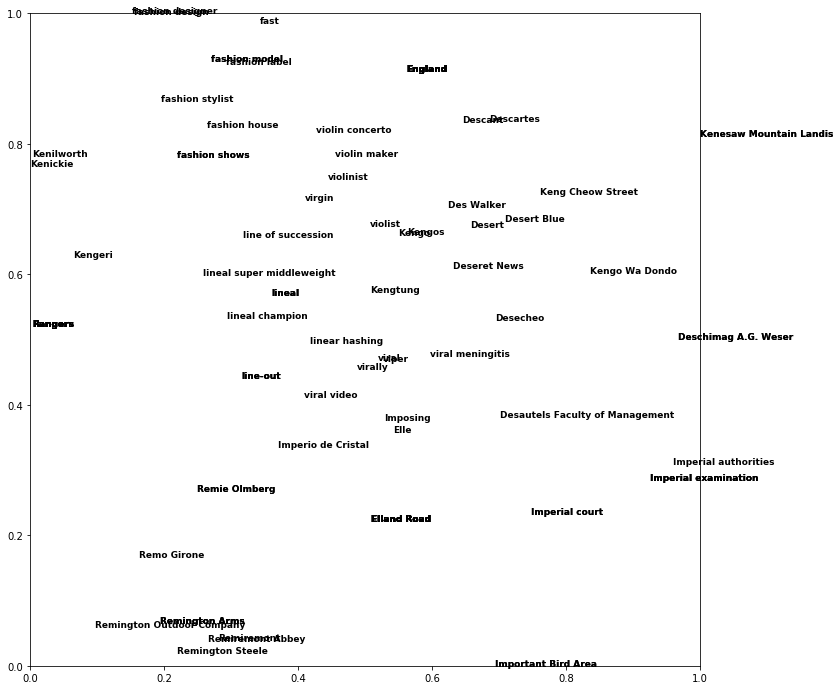

EPOCH - 0, TRAIN LOSS - 15.2652, VALID LOSS - 19.93676, KENDALL - -0.0003, SPEARMAN - 0.0002
EPOCH - 1, TRAIN LOSS - 12.9761, VALID LOSS - 16.59621, KENDALL - 0.0005, SPEARMAN - 0.0005
EPOCH - 2, TRAIN LOSS - 11.0200, VALID LOSS - 14.41577, KENDALL - 0.0064, SPEARMAN - 0.0095
EPOCH - 3, TRAIN LOSS - 9.1215, VALID LOSS - 11.94105, KENDALL - -0.0008, SPEARMAN - -0.0006
EPOCH - 4, TRAIN LOSS - 7.7005, VALID LOSS - 9.97735, KENDALL - 0.0057, SPEARMAN - 0.0087
EPOCH - 5, TRAIN LOSS - 6.6257, VALID LOSS - 8.52133, KENDALL - 0.0047, SPEARMAN - 0.0064
EPOCH - 6, TRAIN LOSS - 5.7847, VALID LOSS - 7.39214, KENDALL - 0.0027, SPEARMAN - 0.0037
EPOCH - 7, TRAIN LOSS - 5.1229, VALID LOSS - 6.50482, KENDALL - 0.0012, SPEARMAN - 0.0008
EPOCH - 8, TRAIN LOSS - 4.5974, VALID LOSS - 5.80455, KENDALL - -0.0003, SPEARMAN - -0.0004
EPOCH - 9, TRAIN LOSS - 4.1695, VALID LOSS - 5.24179, KENDALL - 0.0034, SPEARMAN - 0.0043


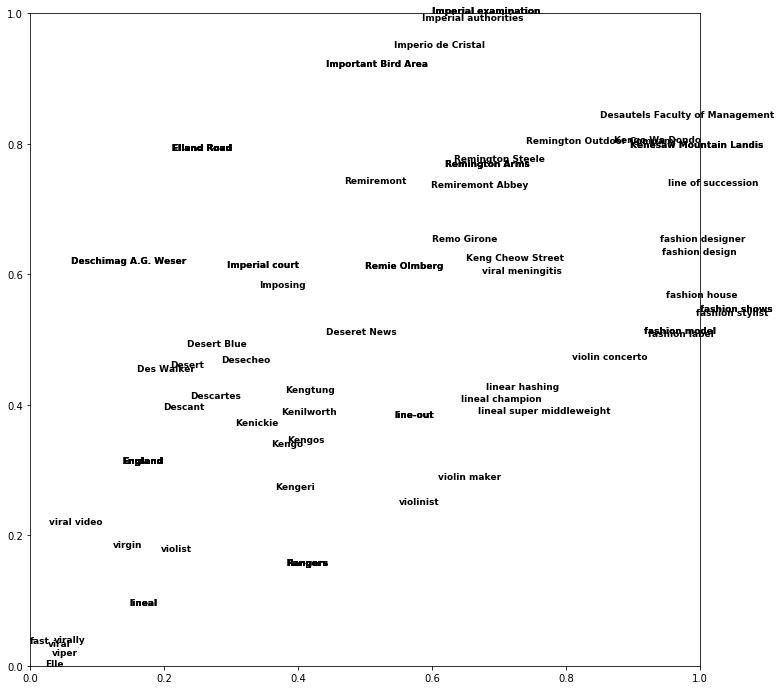

EPOCH - 10, TRAIN LOSS - 3.8128, VALID LOSS - 4.77740, KENDALL - 0.0050, SPEARMAN - 0.0075
EPOCH - 11, TRAIN LOSS - 3.5068, VALID LOSS - 4.38502, KENDALL - 0.0066, SPEARMAN - 0.0100
EPOCH - 12, TRAIN LOSS - 3.2359, VALID LOSS - 4.04213, KENDALL - 0.0009, SPEARMAN - 0.0011
EPOCH - 13, TRAIN LOSS - 2.9953, VALID LOSS - 3.73703, KENDALL - 0.0038, SPEARMAN - 0.0050
EPOCH - 14, TRAIN LOSS - 2.7761, VALID LOSS - 3.46335, KENDALL - 0.0047, SPEARMAN - 0.0063
EPOCH - 15, TRAIN LOSS - 2.5803, VALID LOSS - 3.21286, KENDALL - 0.0057, SPEARMAN - 0.0079
EPOCH - 16, TRAIN LOSS - 2.4109, VALID LOSS - 2.99480, KENDALL - 0.0072, SPEARMAN - 0.0102
EPOCH - 17, TRAIN LOSS - 2.2630, VALID LOSS - 2.80584, KENDALL - 0.0014, SPEARMAN - 0.0022
EPOCH - 18, TRAIN LOSS - 2.1317, VALID LOSS - 2.63942, KENDALL - 0.0043, SPEARMAN - 0.0061
EPOCH - 19, TRAIN LOSS - 2.0137, VALID LOSS - 2.49060, KENDALL - 0.0013, SPEARMAN - 0.0023


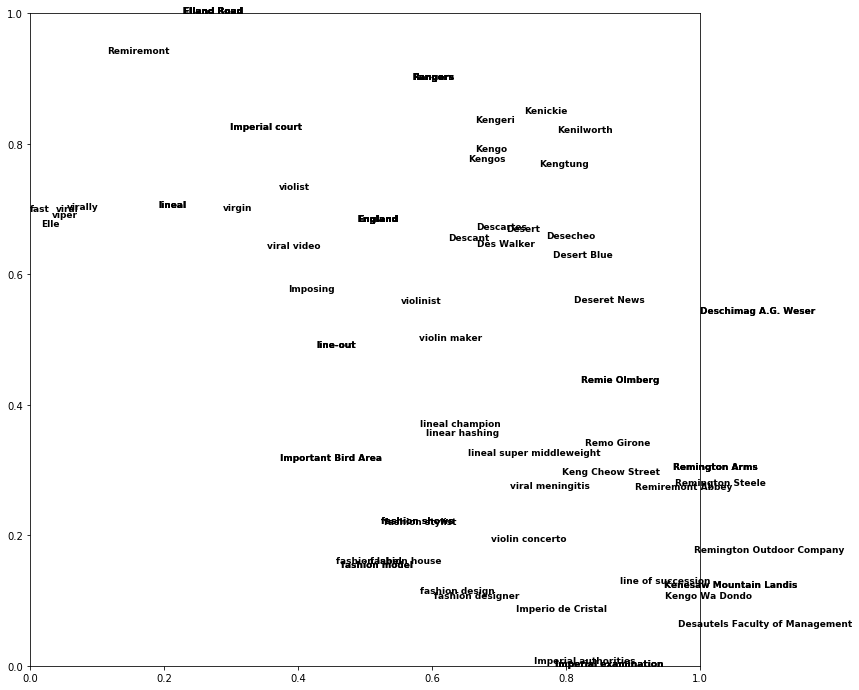

EPOCH - 20, TRAIN LOSS - 1.9066, VALID LOSS - 2.35607, KENDALL - 0.0027, SPEARMAN - 0.0042
EPOCH - 21, TRAIN LOSS - 1.8086, VALID LOSS - 2.23338, KENDALL - 0.0045, SPEARMAN - 0.0068
EPOCH - 22, TRAIN LOSS - 1.7185, VALID LOSS - 2.12076, KENDALL - 0.0035, SPEARMAN - 0.0050
EPOCH - 23, TRAIN LOSS - 1.6352, VALID LOSS - 2.01688, KENDALL - 0.0034, SPEARMAN - 0.0048
EPOCH - 24, TRAIN LOSS - 1.5580, VALID LOSS - 1.92075, KENDALL - 0.0072, SPEARMAN - 0.0102
EPOCH - 25, TRAIN LOSS - 1.4864, VALID LOSS - 1.83158, KENDALL - 0.0014, SPEARMAN - 0.0019
EPOCH - 26, TRAIN LOSS - 1.4196, VALID LOSS - 1.74863, KENDALL - 0.0020, SPEARMAN - 0.0031
EPOCH - 27, TRAIN LOSS - 1.3572, VALID LOSS - 1.67120, KENDALL - 0.0043, SPEARMAN - 0.0063
EPOCH - 28, TRAIN LOSS - 1.2987, VALID LOSS - 1.59865, KENDALL - 0.0050, SPEARMAN - 0.0067
EPOCH - 29, TRAIN LOSS - 1.2435, VALID LOSS - 1.53043, KENDALL - 0.0038, SPEARMAN - 0.0054


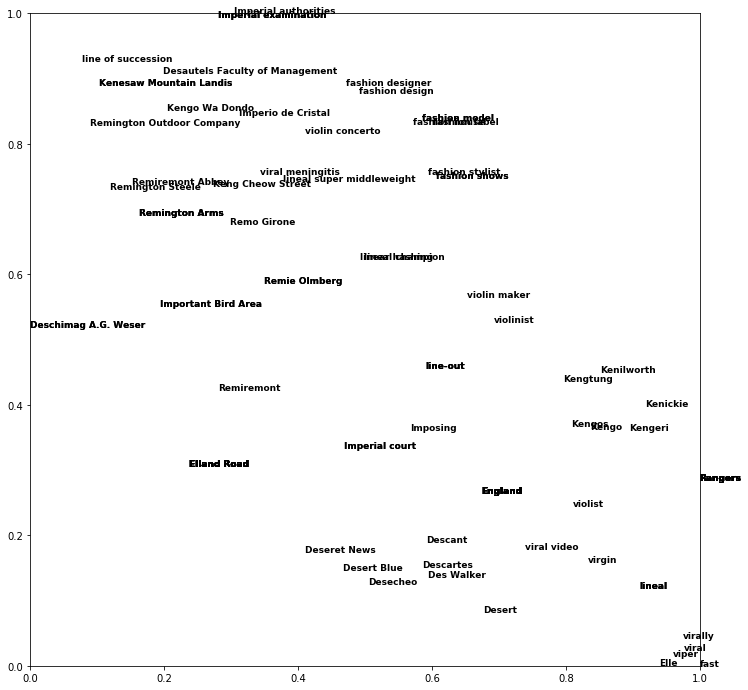

EPOCH - 30, TRAIN LOSS - 1.1913, VALID LOSS - 1.46602, KENDALL - 0.0057, SPEARMAN - 0.0076
EPOCH - 31, TRAIN LOSS - 1.1418, VALID LOSS - 1.40502, KENDALL - 0.0021, SPEARMAN - 0.0022
EPOCH - 32, TRAIN LOSS - 1.0948, VALID LOSS - 1.34705, KENDALL - -0.0011, SPEARMAN - -0.0016
EPOCH - 33, TRAIN LOSS - 1.0499, VALID LOSS - 1.29183, KENDALL - 0.0040, SPEARMAN - 0.0056
EPOCH - 34, TRAIN LOSS - 1.0069, VALID LOSS - 1.23908, KENDALL - 0.0045, SPEARMAN - 0.0061
EPOCH - 35, TRAIN LOSS - 0.9658, VALID LOSS - 1.18859, KENDALL - 0.0007, SPEARMAN - 0.0012
EPOCH - 36, TRAIN LOSS - 0.9264, VALID LOSS - 1.14018, KENDALL - -0.0024, SPEARMAN - -0.0036
EPOCH - 37, TRAIN LOSS - 0.8885, VALID LOSS - 1.09367, KENDALL - -0.0018, SPEARMAN - -0.0025
EPOCH - 38, TRAIN LOSS - 0.8520, VALID LOSS - 1.04894, KENDALL - -0.0050, SPEARMAN - -0.0073
EPOCH - 39, TRAIN LOSS - 0.8169, VALID LOSS - 1.00585, KENDALL - 0.0042, SPEARMAN - 0.0071


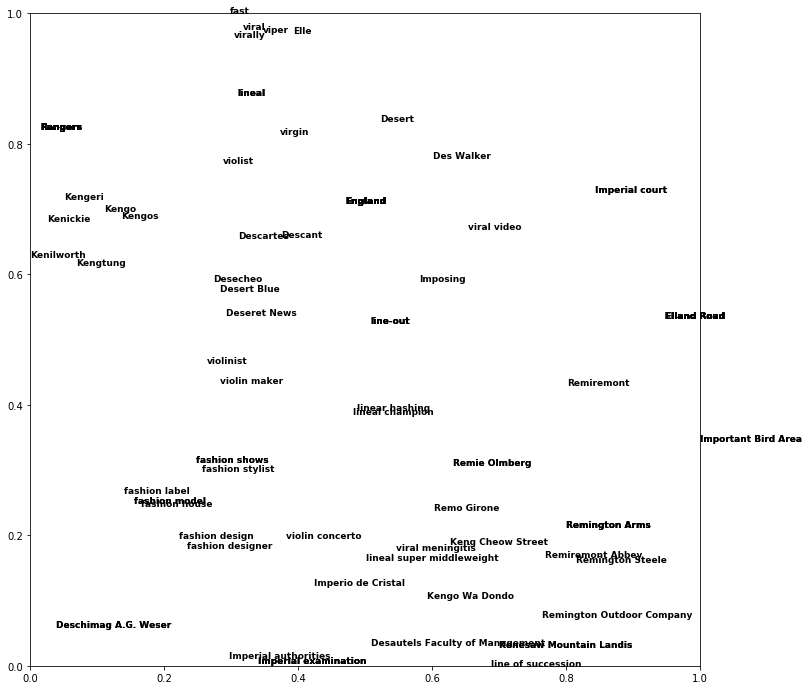

EPOCH - 40, TRAIN LOSS - 0.7830, VALID LOSS - 0.96430, KENDALL - 0.0035, SPEARMAN - 0.0059
EPOCH - 41, TRAIN LOSS - 0.7502, VALID LOSS - 0.92421, KENDALL - 0.0037, SPEARMAN - 0.0062
EPOCH - 42, TRAIN LOSS - 0.7186, VALID LOSS - 0.88550, KENDALL - 0.0004, SPEARMAN - 0.0006
EPOCH - 43, TRAIN LOSS - 0.6881, VALID LOSS - 0.84810, KENDALL - 0.0042, SPEARMAN - 0.0061
EPOCH - 44, TRAIN LOSS - 0.6587, VALID LOSS - 0.81198, KENDALL - 0.0014, SPEARMAN - 0.0019
EPOCH - 45, TRAIN LOSS - 0.6302, VALID LOSS - 0.77707, KENDALL - 0.0035, SPEARMAN - 0.0053
EPOCH - 46, TRAIN LOSS - 0.6027, VALID LOSS - 0.74335, KENDALL - 0.0005, SPEARMAN - 0.0006
EPOCH - 47, TRAIN LOSS - 0.5761, VALID LOSS - 0.71078, KENDALL - 0.0036, SPEARMAN - 0.0054
EPOCH - 48, TRAIN LOSS - 0.5505, VALID LOSS - 0.67932, KENDALL - 0.0006, SPEARMAN - 0.0004
EPOCH - 49, TRAIN LOSS - 0.5257, VALID LOSS - 0.64896, KENDALL - -0.0015, SPEARMAN - -0.0015


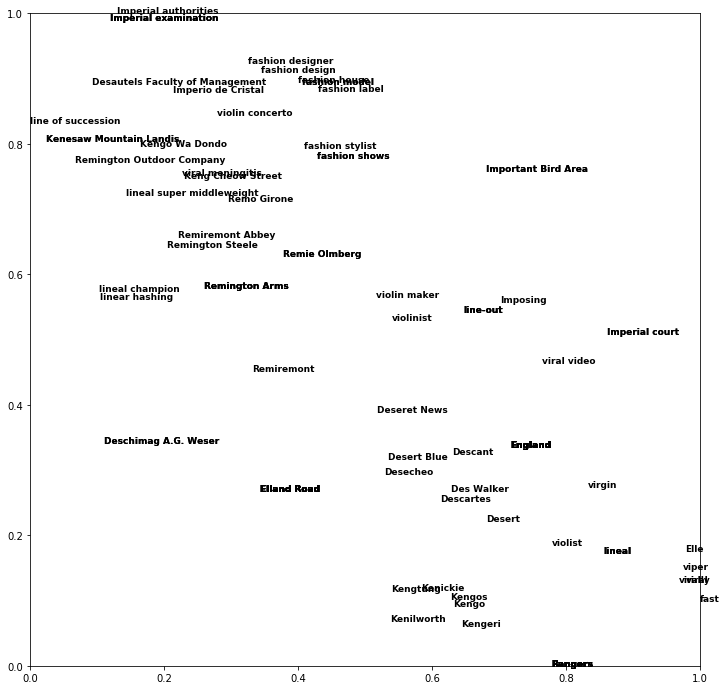

EPOCH - 50, TRAIN LOSS - 0.5018, VALID LOSS - 0.61965, KENDALL - 0.0000, SPEARMAN - 0.0009
EPOCH - 51, TRAIN LOSS - 0.4788, VALID LOSS - 0.59138, KENDALL - -0.0013, SPEARMAN - -0.0011
EPOCH - 52, TRAIN LOSS - 0.4566, VALID LOSS - 0.56411, KENDALL - 0.0026, SPEARMAN - 0.0037
EPOCH - 53, TRAIN LOSS - 0.4352, VALID LOSS - 0.53783, KENDALL - -0.0033, SPEARMAN - -0.0043
EPOCH - 54, TRAIN LOSS - 0.4146, VALID LOSS - 0.51251, KENDALL - -0.0029, SPEARMAN - -0.0044
EPOCH - 55, TRAIN LOSS - 0.3947, VALID LOSS - 0.48812, KENDALL - 0.0045, SPEARMAN - 0.0056
EPOCH - 56, TRAIN LOSS - 0.3756, VALID LOSS - 0.46464, KENDALL - 0.0051, SPEARMAN - 0.0076
EPOCH - 57, TRAIN LOSS - 0.3572, VALID LOSS - 0.44204, KENDALL - 0.0001, SPEARMAN - -0.0004
EPOCH - 58, TRAIN LOSS - 0.3396, VALID LOSS - 0.42028, KENDALL - 0.0028, SPEARMAN - 0.0032
EPOCH - 59, TRAIN LOSS - 0.3226, VALID LOSS - 0.39936, KENDALL - 0.0014, SPEARMAN - 0.0010


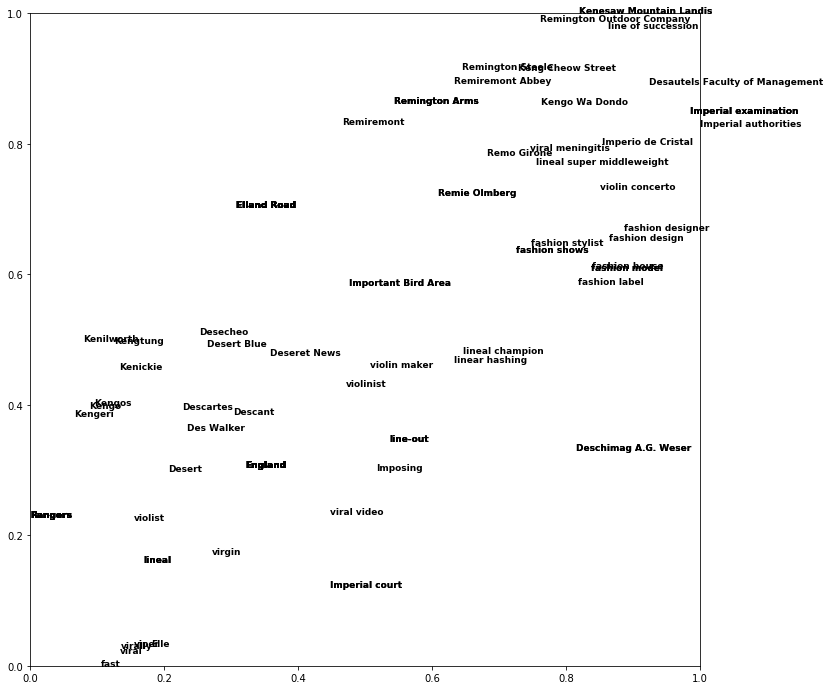

EPOCH - 60, TRAIN LOSS - 0.3062, VALID LOSS - 0.37925, KENDALL - 0.0034, SPEARMAN - 0.0041
EPOCH - 61, TRAIN LOSS - 0.2906, VALID LOSS - 0.35995, KENDALL - 0.0019, SPEARMAN - 0.0030
EPOCH - 62, TRAIN LOSS - 0.2756, VALID LOSS - 0.34143, KENDALL - 0.0033, SPEARMAN - 0.0047
EPOCH - 63, TRAIN LOSS - 0.2612, VALID LOSS - 0.32372, KENDALL - 0.0030, SPEARMAN - 0.0044
EPOCH - 64, TRAIN LOSS - 0.2475, VALID LOSS - 0.30681, KENDALL - 0.0039, SPEARMAN - 0.0058
EPOCH - 65, TRAIN LOSS - 0.2345, VALID LOSS - 0.29065, KENDALL - 0.0047, SPEARMAN - 0.0073
EPOCH - 66, TRAIN LOSS - 0.2221, VALID LOSS - 0.27531, KENDALL - -0.0002, SPEARMAN - -0.0005
EPOCH - 67, TRAIN LOSS - 0.2103, VALID LOSS - 0.26074, KENDALL - -0.0006, SPEARMAN - -0.0013
EPOCH - 68, TRAIN LOSS - 0.1991, VALID LOSS - 0.24688, KENDALL - 0.0000, SPEARMAN - 0.0002
EPOCH - 69, TRAIN LOSS - 0.1885, VALID LOSS - 0.23374, KENDALL - 0.0040, SPEARMAN - 0.0059


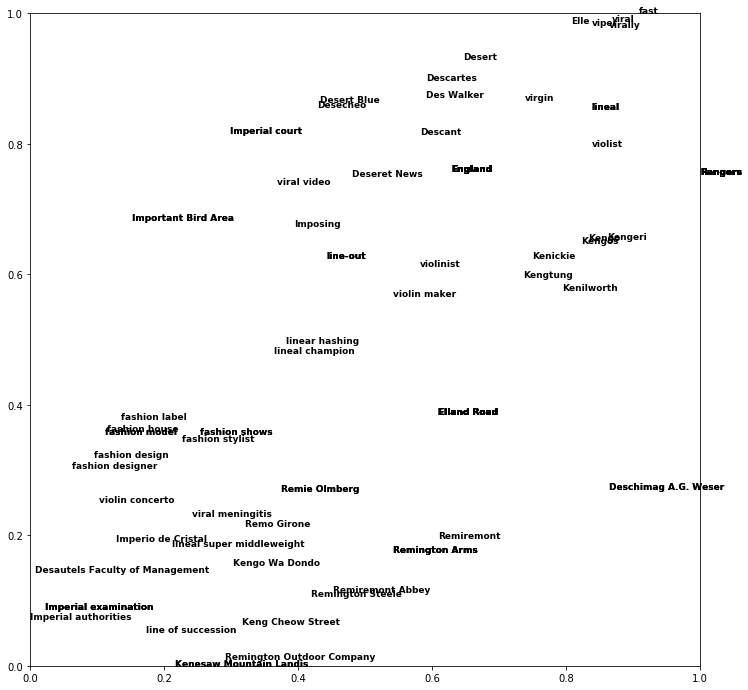

EPOCH - 70, TRAIN LOSS - 0.1784, VALID LOSS - 0.22124, KENDALL - 0.0045, SPEARMAN - 0.0066
EPOCH - 71, TRAIN LOSS - 0.1688, VALID LOSS - 0.20929, KENDALL - 0.0074, SPEARMAN - 0.0103
EPOCH - 72, TRAIN LOSS - 0.1596, VALID LOSS - 0.19791, KENDALL - 0.0069, SPEARMAN - 0.0101
EPOCH - 73, TRAIN LOSS - 0.1507, VALID LOSS - 0.18704, KENDALL - 0.0089, SPEARMAN - 0.0124
EPOCH - 74, TRAIN LOSS - 0.1423, VALID LOSS - 0.17658, KENDALL - 0.0032, SPEARMAN - 0.0046
EPOCH - 75, TRAIN LOSS - 0.1341, VALID LOSS - 0.16654, KENDALL - 0.0060, SPEARMAN - 0.0091
EPOCH - 76, TRAIN LOSS - 0.1263, VALID LOSS - 0.15683, KENDALL - 0.0085, SPEARMAN - 0.0114
EPOCH - 77, TRAIN LOSS - 0.1187, VALID LOSS - 0.14754, KENDALL - 0.0072, SPEARMAN - 0.0104
EPOCH - 78, TRAIN LOSS - 0.1115, VALID LOSS - 0.13861, KENDALL - 0.0078, SPEARMAN - 0.0112
EPOCH - 79, TRAIN LOSS - 0.1046, VALID LOSS - 0.13003, KENDALL - 0.0069, SPEARMAN - 0.0108


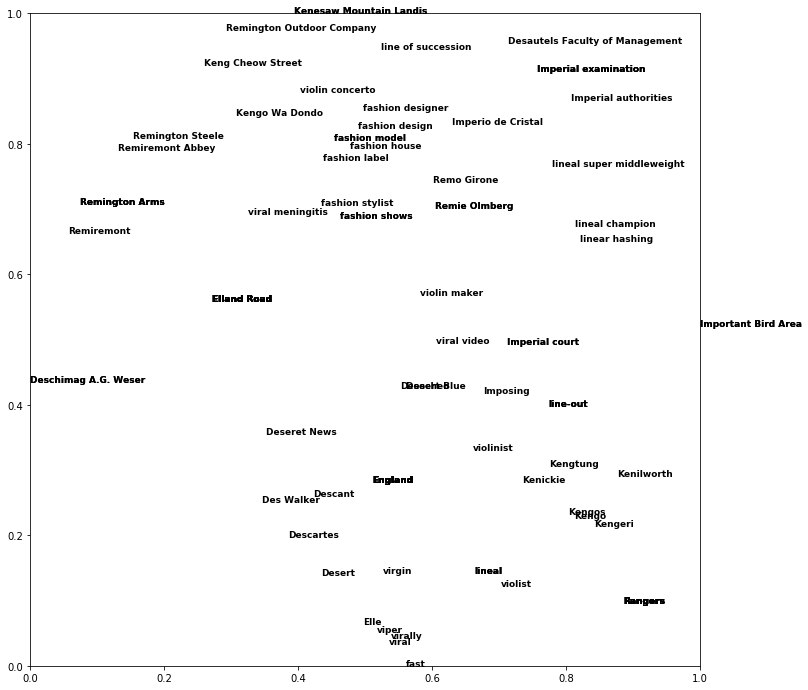

EPOCH - 80, TRAIN LOSS - 0.0981, VALID LOSS - 0.12194, KENDALL - 0.0082, SPEARMAN - 0.0123
EPOCH - 81, TRAIN LOSS - 0.0920, VALID LOSS - 0.11429, KENDALL - 0.0075, SPEARMAN - 0.0114
EPOCH - 82, TRAIN LOSS - 0.0863, VALID LOSS - 0.10714, KENDALL - 0.0068, SPEARMAN - 0.0101
EPOCH - 83, TRAIN LOSS - 0.0810, VALID LOSS - 0.10052, KENDALL - 0.0009, SPEARMAN - 0.0014
EPOCH - 84, TRAIN LOSS - 0.0761, VALID LOSS - 0.09438, KENDALL - 0.0033, SPEARMAN - 0.0048
EPOCH - 85, TRAIN LOSS - 0.0716, VALID LOSS - 0.08870, KENDALL - 0.0046, SPEARMAN - 0.0071
EPOCH - 86, TRAIN LOSS - 0.0674, VALID LOSS - 0.08344, KENDALL - 0.0046, SPEARMAN - 0.0067
EPOCH - 87, TRAIN LOSS - 0.0635, VALID LOSS - 0.07853, KENDALL - 0.0041, SPEARMAN - 0.0061
EPOCH - 88, TRAIN LOSS - 0.0598, VALID LOSS - 0.07395, KENDALL - 0.0021, SPEARMAN - 0.0032
EPOCH - 89, TRAIN LOSS - 0.0563, VALID LOSS - 0.06962, KENDALL - 0.0018, SPEARMAN - 0.0014


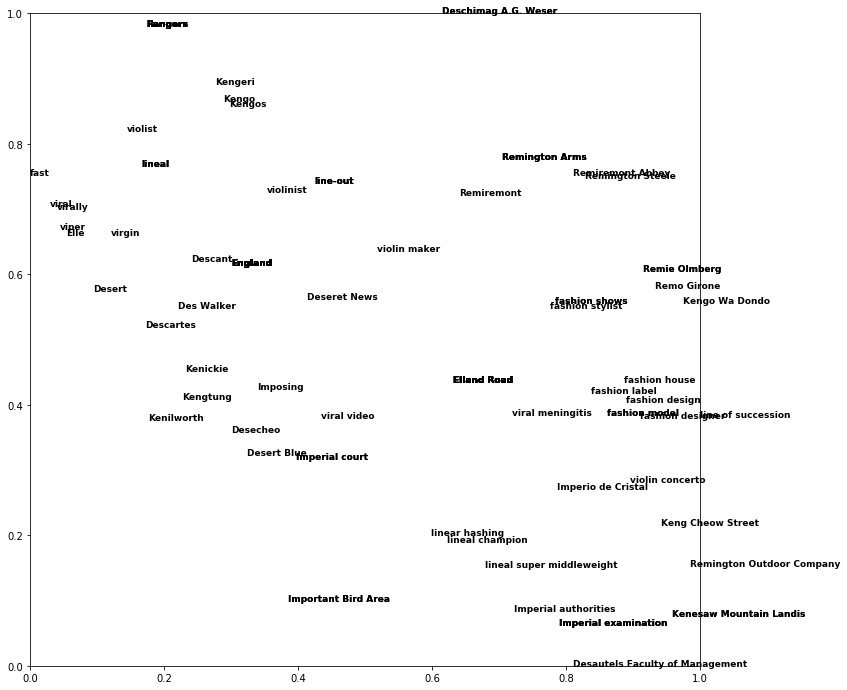

EPOCH - 90, TRAIN LOSS - 0.0530, VALID LOSS - 0.06554, KENDALL - 0.0062, SPEARMAN - 0.0090
EPOCH - 91, TRAIN LOSS - 0.0498, VALID LOSS - 0.06166, KENDALL - 0.0102, SPEARMAN - 0.0146
EPOCH - 92, TRAIN LOSS - 0.0466, VALID LOSS - 0.05781, KENDALL - 0.0113, SPEARMAN - 0.0153
EPOCH - 93, TRAIN LOSS - 0.0435, VALID LOSS - 0.05395, KENDALL - 0.0089, SPEARMAN - 0.0124
EPOCH - 94, TRAIN LOSS - 0.0407, VALID LOSS - 0.05036, KENDALL - 0.0062, SPEARMAN - 0.0085
EPOCH - 95, TRAIN LOSS - 0.0381, VALID LOSS - 0.04716, KENDALL - 0.0041, SPEARMAN - 0.0061
EPOCH - 96, TRAIN LOSS - 0.0359, VALID LOSS - 0.04429, KENDALL - 0.0075, SPEARMAN - 0.0110
EPOCH - 97, TRAIN LOSS - 0.0337, VALID LOSS - 0.04162, KENDALL - 0.0010, SPEARMAN - 0.0017
EPOCH - 98, TRAIN LOSS - 0.0317, VALID LOSS - 0.03911, KENDALL - -0.0023, SPEARMAN - -0.0033
EPOCH - 99, TRAIN LOSS - 0.0297, VALID LOSS - 0.03671, KENDALL - 0.0024, SPEARMAN - 0.0032


In [216]:
for epoch in range(100):
    if epoch % 10 == 0:
        plot_tsne = True
    else:
        plot_tsne = False
    valid_loss, kendall_score, spearman_score = validator.validate(Model, Dev_arr, plot_tsne=plot_tsne)
    train_loss = train_epoch(Model, Optimizer, Loss_fn, Train_arr)
    print('EPOCH - {}, TRAIN LOSS - {:.4f}, VALID LOSS - {:.5f}, KENDALL - {:.4f}, SPEARMAN - {:.4f}'
          .format(epoch, train_loss, valid_loss, kendall_score, spearman_score))  

## Check Learned Weights

In [ ]:
state_dict = Model.state_dict()
lin1_W = state_dict['lin1.weight']
lin1_b = state_dict['lin1.bias']
lin2_W = state_dict['lin2.weight']
lin2_b = state_dict['lin2.bias']

In [ ]:
plt.matshow(lin1_W)

In [ ]:
plt.matshow(lin2_W)